In [1]:
# загружаем датасет с kaggle 
# https://www.kaggle.com/datasets/lyly99/logodet3k
#import kagglehub
#lyly99_logodet3k_path = kagglehub.dataset_download('lyly99/logodet3k')

#print('Data source import complete.')


In [2]:
#lyly99_logodet3k_path

In [3]:
lyly99_logodet3k_path = '/home/pavel/.cache/kagglehub/datasets/lyly99/logodet3k/versions/1'

In [4]:
import numpy as np
import torch
import cv2
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
import matplotlib.pyplot as plt

import os

Посмотрим на пример изображения из датасета

In [5]:
img = cv2.imread(os.path.join(lyly99_logodet3k_path, "LogoDet-3K/Food/Adnams/1.jpg"))

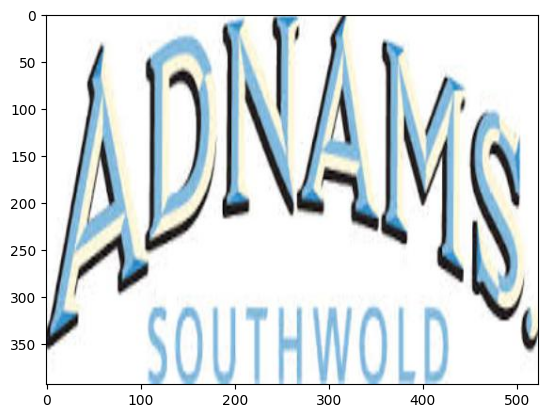

In [6]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Возьмем из датасета 10 команий

In [7]:
def preproc_img(img):
    """
    для того чтобы засунуть изображения в numpy array приведем их к одному размеру
    так же стандартный препроцессор, который идет с CLIP обрезает картинку до заданного размера
    а мы уменьшим, не обрезая
    и сразу переведем из BRG -> RGB
    """
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (224, 224))


def get_data(num_classes, data_path):
    """
    загружаем данные
    для примера, будем брать только из Leisure
    """
    
    X = []
    y = []

    class_names = []
    for dirname, classes, _ in os.walk(os.path.join(data_path, 'LogoDet-3K/Leisure')):
        class_names = classes[:num_classes]
        break

    img_paths = []
    for class_name in class_names:
        path = os.path.join(data_path, 'LogoDet-3K/Leisure', class_name)
        filenames = os.listdir(path)
        img_paths.append([os.path.join(path, filename) for filename in filenames if filename.endswith('.jpg')])

    for class_idx, (class_name, img_class_paths) in enumerate(zip(class_names, img_paths)):
        y += [class_idx] * len(img_class_paths)
        X += [preproc_img(cv2.imread(path)) for path in img_class_paths]

    X = np.array(X)
    y = np.array(y)

    return X, y, class_names

In [8]:
num_classes = 10
X, y, class_names = get_data(num_classes, lyly99_logodet3k_path)

In [9]:
class_names

['Baron von Redberry',
 'HMV',
 'mtx audio',
 'nerf',
 'pound puppies',
 'sound city',
 'play-doh',
 'adika',
 'pixy stix',
 'scrabble']

In [10]:
X.shape

(536, 224, 224, 3)

Для получение эмбеддингов будем использовать энкодер изображений из CLIP

In [11]:
def get_model_info(model_ID, device):
    # берем уже обученные модели
	model = CLIPModel.from_pretrained(model_ID).to(device)
	processor = CLIPProcessor.from_pretrained(model_ID)
	
	return model, processor
    
device = "cuda:1" if torch.cuda.is_available() else "cpu"
model_ID = "openai/clip-vit-base-patch32"

model, processor = get_model_info(model_ID, device)

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [12]:
# получаем эмбеддинги изображений, перед этим предобработав их
images = processor(
        text = None,
        images = X,
        return_tensors="pt"
        )["pixel_values"].to(device)
embedding = model.get_image_features(images)

In [13]:
embedding.shape

torch.Size([536, 512])

загрузим 5 изображений логотипа компании, которую мы до этого не видели

In [14]:
example_imgs = [preproc_img(cv2.imread(f'./adnas/{i}.jpg')) for i in [1, 11, 12, 2]]
test_img = preproc_img(cv2.imread('./adnas/10.jpg'))

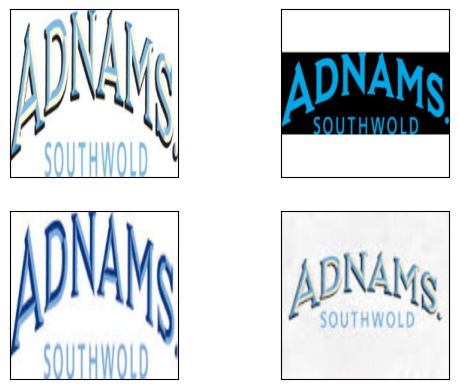

In [15]:
for ind, img in enumerate(example_imgs):
    plt.subplot(2, 2, ind + 1)
    plt.imshow(img)
    
    plt.xticks([])
    plt.yticks([])


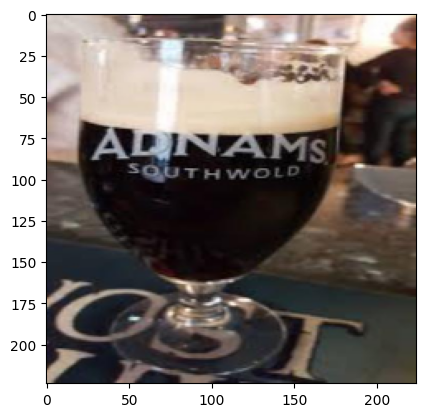

In [16]:
plt.imshow(test_img)

Получим их эмбеддинги

In [17]:
images = processor(
        text = None,
        images = example_imgs,
        return_tensors="pt"
        )["pixel_values"].to(device)
example_emb = model.get_image_features(images)

In [18]:
images = processor(
        text = None,
        images = test_img,
        return_tensors="pt"
        )["pixel_values"].to(device)
test_emb = model.get_image_features(images).cpu().detach().numpy()

In [19]:
all_emb = torch.cat((embedding, example_emb), 0)
all_emb.size()

torch.Size([540, 512])

Добавим новую метку

In [20]:
all_y = np.concatenate((y, np.full(len(example_imgs), len(class_names))))

Для классификации будем использовать обычный kNN, с метрикой - Косинусное расстояние

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_clf.fit(all_emb.cpu().detach().numpy(), all_y)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [22]:
knn_clf.predict(test_emb)

array([10])

Получили правильный класс!

Эмбеддинги других компаний нужны в качестве негативов, чтобы knn корректно работал

Для интереса посмотрим на проекцию эмбеддингов с помощью tsne

In [ ]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, learning_rate='auto',
                init='random', perplexity=7)
tsne = tsne.fit_transform(all_emb.cpu().detach().numpy())
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=all_y, s=20, cmap='jet', alpha=0.7)